# **MÁSTER BIG DATA Y DATA SCIENCE**

---

### **Mapas de atención visual basados en redes neuronales para la búsqueda de predicciones**



*   #### Curso: Trabajo fin de máster
*   #### Autor:  María Alonso Arroyo
*   #### Fecha entrega: 30/09/21












In [ ]:
# Se importa la función de drive que es donde se encuentra el dataset
from google.colab import drive

# Esto provocará la autorización
drive.mount('/content/drive')

# Se cambia el directorio
import os
os.chdir('/content/drive/My Drive/MASTER/TFM/TFM_CNN_training')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#### Librerías 


In [ ]:
pip install multimatch-gaze

In [ ]:
import numpy  as np
import matplotlib.pyplot as plt  
import cv2 as cv                 # Importa opencv
plt.style.use('default')
from os import listdir
from keras import backend as K
import tensorflow as tf

from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from imageio import imread

import skimage.io as io          # Importa skimage necesario para leer imágenes como arrays
from skimage.transform import rescale
from skimage import color
from skimage.measure import label
from skimage.morphology import extrema
from skimage import exposure

import multimatch_gaze as m

#### Funciones

In [ ]:
def normalize_map(s_map):
    # Normaliza el mapa de prominencia
    norm_s_map = (s_map - np.min(s_map))/((np.max(s_map)-np.min(s_map))*1.0)
    return norm_s_map

In [ ]:
# Determina los peaks necesarios
def peaks():
  a = np.arange(3,13,1) # El resultado es un array [3 a 12]
  # Asigna probabilidades a cada número 
  p = np.asarray([9, 89, 405, 1098, 1952, 2466, 2461, 1256, 252, 12], dtype= np.float16 )
  p[:] = [x / 10000 for x in p]
  result = np.random.choice(a, p=p)
  return result

#### Variables globales

In [ ]:
# Tamaño de entrada a la CNN
in_rows = 240
in_cols = 320

# Tamaño de salida a la CNN
out_rows = 240
out_cols = 320

# Rutas
path_imgs = "/content/drive/My Drive/MASTER/TFM/SALICON/images/train2014/"
path_maps = "/content/drive/My Drive/MASTER/TFM/SALICON/maps/train/"
path_imgs_test = "/content/drive/My Drive/MASTER/TFM/SALICON/images/val2014/"
path_maps_test = "/content/drive/My Drive/MASTER/TFM/SALICON/maps/val/"

path_fixs = "/content/drive/My Drive/MASTER/TFM/SALICON/fix_maps/train/"
path_fixs_test = "/content/drive/My Drive/MASTER/TFM/SALICON/fix_maps/val/"

path_predic = "/content/drive/My Drive/MASTER/TFM/predictions/test/"
path_pred_val = "/content/drive/My Drive/MASTER/TFM/predictions/val/"
#path_weights= "/content/drive/My Drive/MASTER/TFM/tmp2"
weights_filename = 'imagenet-vgg-m.mat'

font = cv.FONT_HERSHEY_SIMPLEX


#### PREPROCESAMIENTO

#### Función que procesa previamente las imágenes antes de introducirlas en la arquitectura de CNN

In [ ]:
def preprocess_images(paths, in_rows, in_cols):
  

    for i, path in enumerate(paths):
        original_image = io.imread(path)  ims = np.zeros((len(paths), in_rows, in_cols, 3))
        ims[i] = rescale(original_image, 1.0 / 2.0, anti_aliasing=False)
        
    ims[:, :, :, 0] -= 126.763/255     #103.939/255
    ims[:, :, :, 1] -= 121.651/255     #116.779/255
    ims[:, :, :, 2] -= 114.519/255     #123.68/255

    
    return ims

#### Funciones que preprocesan los mapas de la verdad y el mapa de fijaciones antes de introducirlos en la arquitectura de CNN

In [ ]:
def preprocess_maps(paths, in_rows, in_cols):
    ims = np.zeros((len(paths), in_rows, in_cols, 1))

    for i, path in enumerate(paths):
        original_map = io.imread(path)
        ims[i,:,:,0] = rescale(original_map.astype(np.float32), 1.0 / 2.0, anti_aliasing=False)   #Reducida a la mitad
        ims[i,:,:,0] /= 255.0
   
    return ims

In [ ]:
def preprocess_fixs(paths, in_rows, in_cols):
    ims = np.zeros((len(paths), in_rows, in_cols, 1))

    for i, path in enumerate(paths):
        original_map = color.rgb2gray(io.imread(path))
        ims[i,:,:,0] = rescale(original_map.astype(np.float32), 1.0 / 2.0, anti_aliasing=False)   #Reducida a la mitad
        ims[i,:,:,0] = normalize_map(ims[i,:,:,0])
        r,c = np.nonzero(ims[i,:,:,0])
        # Después de cambiar la escala, los valores de intensidad cambian -> Conversión de imagen a binaria
        for j in range (len(r)):
          ims[i,r[j],c[j],0]=1
   
    return ims

#### Función que define el generador que será utilizado por la función fit_generator para leer imágenes durante el proceso de entrenamiento.

In [ ]:
def generator(b_s, phase_gen='train'):
    
    list_images = [path_imgs + f for f in os.listdir(path_imgs) 
                   if f.endswith(('.jpg', '.jpeg', '.png'))]
    list_maps = [path_maps + f for f in os.listdir(path_maps) 
                 if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Hace correspondencia entre imágenes y mapas 
    list_images.sort()
    list_maps.sort()
    
    if phase_gen == 'train':
        images = list_images[0:9000]
        maps = list_maps[0:9000]
    elif phase_gen == 'val':
        images = list_images[9000:]
        maps = list_maps[9000:]
    else: 
        raise NotImplementedError

    counter = 0
    while True:
        Y = preprocess_maps(maps[counter:counter+b_s], out_rows, out_cols)
        yield preprocess_images(images[counter:counter+b_s],in_rows, in_cols),Y
        counter = (counter + b_s) % len(images)

#### Función que define el generador que leerá imágenes de prueba para probar el desempeño de la arquitectura CNN

In [ ]:
def generator_test(b_s, path_imgs_test):
    images = [path_imgs_test + f for f in os.listdir(path_imgs_test) if f.endswith(('.jpg', '.jpeg', '.png'))]
    maps = [path_maps_test + f for f in os.listdir(path_maps_test) if f.endswith(('.jpg', '.jpeg', '.png'))]
    fixs = [path_fixs_test + f for f in os.listdir(path_fixs_test) if f.endswith(('.jpg', '.jpeg', '.png'))]
    images.sort()
    maps.sort()
    fixs.sort()

    counter = 0
    while True:
        Y = preprocess_maps(maps[counter:counter+b_s], out_rows, out_cols)
        F = preprocess_fixs(fixs[counter:counter+b_s], out_rows, out_cols)
        return preprocess_images(images[counter:counter + b_s], in_rows, in_cols),Y, F
        counter = (counter + b_s) % len(images)

#### Función que nos permite replicar elementos mediante tensorflow

In [ ]:
def repeat_elements(x,rep,axis):
    x_shape = x.get_shape().as_list()
    reps = np.ones(len(x_shape))
    reps[axis] = rep
    x_rep = tf.tile(x,reps)
    return x_rep

#### Función que implementa la métrica de divergencia Kullback Leibler en 2D que mide la diferencia entre dos distribuciones de probabilidad (mapas gaussianos y mapas de predicción).

In [ ]:
# KL-Divergence Loss
def kl_divergence_2d(y_true, y_pred):
    min_y_true = repeat_elements(K.expand_dims(repeat_elements(K.expand_dims(K.min(K.min(y_true, axis=1), axis=1)), 
                                                                   in_rows, axis=1)), in_cols, axis=2)
    min_y_pred = repeat_elements(K.expand_dims(repeat_elements(K.expand_dims(K.min(K.min(y_pred, axis=1), axis=1)), 
                                                                   in_rows, axis=1)), in_cols, axis=2)
    max_y_true = repeat_elements(K.expand_dims(repeat_elements(K.expand_dims(K.max(K.max(y_true, axis=1), axis=1)), 
                                                                   in_rows, axis=1)), in_cols, axis=2)
    max_y_pred = repeat_elements(K.expand_dims(repeat_elements(K.expand_dims(K.max(K.max(y_pred, axis=1), axis=1)), 
                                                                   in_rows, axis=1)), in_cols, axis=2)
    y_true = (y_true - min_y_true) / (max_y_true - min_y_true + K.epsilon())
    y_pred = (y_pred - min_y_pred) / (max_y_pred - min_y_pred + K.epsilon())

    sum_y_true = repeat_elements(K.expand_dims(repeat_elements(K.expand_dims(K.sum(K.sum(y_true, axis=1), axis=1)), 
                                                                   out_rows, axis=1)), out_cols, axis=2)
    sum_y_pred = repeat_elements(K.expand_dims(repeat_elements(K.expand_dims(K.sum(K.sum(y_pred, axis=1), axis=1)), 
                                                                   out_rows, axis=1)), out_cols, axis=2)
    
    y_true = K.clip(y_true / (sum_y_true + K.epsilon()), K.epsilon(), 1)
    y_pred = K.clip(y_pred / (sum_y_pred + K.epsilon()), K.epsilon(), 1)
    
    return K.sum(K.sum(y_true * K.log(y_true / y_pred), axis=2), axis=1)

#### Función que carga pesos 

In [ ]:
def load_matconvnet_weights(model, weights_filename, idx_layers=[0,4,8]):
    data = loadmat(weights_filename,matlab_compatible=False,struct_as_record=False) 
     
    layers = data['layers'][0]
    
    for i in idx_layers:
        weights = layers[i][0][0].weights[0,0]
        bias = np.squeeze(layers[i][0][0].weights[0,1])
        model.get_layer(layers[i][0][0].name[0]).set_weights([weights,bias])
    
    return model

#### EVALUACIÓN DE LAS MÉTRICAS

#### Función que calcula el área bajo la curva

In [ ]:
def sAUC_Zhang(smap,gt,other_map,splits=100,stepsize=0.01):
    # smap es el mapa de prominencia o saliency map
    # gt es el mapa de fijación humana (matriz binaria)
    # other_map es un mapa de fijación binario tomando la unión de
    # fijaciones de M otras imágenes aleatorias 
    # splits es el número de divisiones aleatorias
    # stepsize sirve para recorrer el mapa de prominencia
    
    eps = np.finfo(float).eps
    
    # Se normaliza el saliency map
    smap = (smap-np.min(smap))/(np.max(smap)-np.min(smap)+eps)
    smap=np.nan_to_num(smap)
    other_map = (other_map-np.min(other_map))/(np.max(other_map)-np.min(other_map)+eps)
    other_map=np.nan_to_num(other_map)
    
    # Hace del mapa de prominencia, otro mapa del tamaño del mapa de fijación
    S = np.reshape(smap,-1)
    F = np.reshape(gt,-1)
    Oth = np.reshape(other_map,-1)
    
    Sth = S[F>0]; 
    Nfixations = len(Sth)
    
    # Para cada fijación,  se muestra los valores de Nsplits del mapa en ubicaciones
    # especificadas por otherMap
    ind = np.where(Oth>0)[0] # Encuentra ubicaciones de fijación en las imágenes
    pind = Oth[ind]
    pind = pind/(np.sum(pind)+eps)
    if np.sum(np.isnan(pind)) == np.size(pind):
        pind = (1.0/np.size(pind))*np.ones(np.shape(pind))
    
    Nfixations_oth = np.minimum(Nfixations,len(ind))
    randfix = [];
    
    for i in np.arange(splits):
        randind = np.random.choice(ind,Nfixations_oth,p=pind)
        randfix.append(S[randind])
        
    # Calcula el área bajo la curva por random split (aleatorias)
    if Nfixations > 0:
        auc = [] # nan(1,Nsplits);
        for s in np.arange(splits):
            
            curfix = randfix[s]
            
            allthreshes = np.flip(np.arange(0,np.double(np.max([Sth,curfix]))+stepsize,stepsize), axis=0)
            tp = np.zeros(len(allthreshes)+2)
            fp = np.zeros(len(allthreshes)+2)
            tp[0]=0; tp[-1] = 1
            fp[0]=0; fp[-1] = 1
            
            for i in np.arange(len(allthreshes)):
                thresh = allthreshes[i]
                tp[i+1] = np.sum((Sth >= thresh))/Nfixations
                fp[i+1] = np.sum((curfix >= thresh))/Nfixations_oth
            
            auc.append(np.trapz(tp,fp)) # Media sobre el área bajo la curva
        
        score = np.mean(auc) 
        if np.isnan(score):
            score = 0
    else:
        score = np.nan
        tp = []
        fp = []
	
    return score

In [ ]:
def nss(smap,gt):
    # smap es el mapa de prominencia o saliency map
    # gt es el mapa de fijación humana (matriz binaria)
    
	  # Hace que el saliency map sea del tamaño del mapa de fijación
    if np.shape(smap)[0]!=np.shape(gt)[0] or np.shape(smap)[1]!=np.shape(gt)[1]:
        smap = rescale(smap, np.shape(gt),anti_aliasing='False')

    # Normaliza el saliency map
    smap = (smap-np.min(smap))/(np.max(smap)-np.min(smap))
    smap=np.nan_to_num(smap)
    
    S = np.reshape(smap,-1)
    F = np.reshape(gt,-1)
    
    Sth = S[F>0];
    Sth_norm = (Sth - np.mean(smap))/np.std(smap)
    
    NSSscore = np.mean(Sth_norm)
    
    return NSSscore

In [ ]:
def kldiv(s_map,gt):
    s_map = normalize_map(s_map)
    s_map /= (np.sum(s_map)*1.0)
    gt = gt/(np.sum(gt)*1.0)
    eps = 2.2204e-16
    res = gt * np.log(eps + gt/(s_map + eps))
    return np.sum(res)

#### Arquitectura redes neuronales (CNN)


 #### Arquitectura inicial


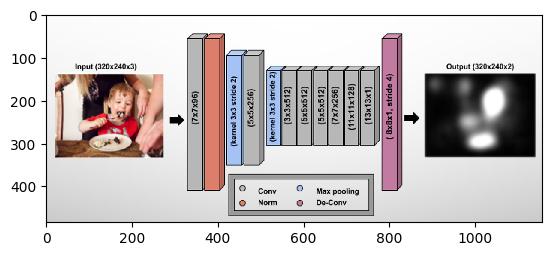

In [ ]:
arch = io.imread('CNN_Architecture.PNG')
plt.imshow(arch)
plt.show()

#### Función que define LNR para implementar la capa de normalización en Keras




In [ ]:
def LRN(x):
    import tensorflow as tf
    return tf.nn.local_response_normalization(x)

#### Función que define las Convolution layers

In [ ]:
def conv2D(filters, k_s, n_conv, act='relu'):
  
    conv_layer = Conv2D(filters,(k_s,k_s),padding='same',activation=act,
                kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=2),
                bias_initializer=Constant(value=0.1), name=n_conv)
    
    return conv_layer

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Lambda, UpSampling2D
from keras.optimizers import Adam
from keras.initializers import RandomNormal, Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint

b_s = 32
epochs = 25 

# Función seed () aleatoria (para los pesos)
#seed(3)

model = Sequential()
model.add(Conv2D(96,(7,7),padding='same',activation='relu',
                kernel_initializer=RandomNormal(mean=0.0, stddev=0.01,seed=2),
                bias_initializer=Constant(value=0.1), name='conv1',
                input_shape=(240,320,3)))
model.add(Lambda(LRN))
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='same'))
model.add(conv2D(256, 5, n_conv='conv2'))
model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='same'))
model.add(conv2D(512, 3, n_conv='conv3'))
model.add(conv2D(512, 5, n_conv='conv4'))
model.add(conv2D(512, 5, n_conv='conv5'))
model.add(conv2D(256, 7, n_conv='conv6'))
model.add(conv2D(128, 11, n_conv='conv7'))
model.add(conv2D(1, 13, n_conv='conv8'))
#model.add(UpSampling2D(size=(16, 16)))
#model.add(Conv2D(1,(8,8),strides=(4,4),padding='same',activation='relu',
#                kernel_initializer=RandomNormal(mean=0.0, stddev=0.01,seed=2),
#                bias_initializer=Constant(value=0.1), name='convOut'))
model.add(Conv2DTranspose(1,(8,8),strides=4,padding='same',activation=None,
                kernel_initializer=RandomNormal(mean=0.0, stddev=0.01,seed=2),
                bias_initializer=Constant(value=0.1)))

# Carga los pesos de un fichero de matlab
load_matconvnet_weights(model, weights_filename)

model.load_weights(filepath='tmp2/weights.24.hdf5')
model.compile(loss=kl_divergence_2d, optimizer=Adam(lr=0.00001)) #metrics=[kl_divergence_2d] 
              # Default lr parameter = 0.001
  
# ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
checkpointer = ModelCheckpoint(filepath='tmp4/weights.{epoch:02d}.hdf5', verbose=1, save_best_only=True)

# EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=False)

W0716 12:09:25.216133 139787602458496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 12:09:25.272207 139787602458496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 12:09:25.280038 139787602458496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0716 12:09:25.313764 139787602458496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0716 12:09:32.221543 139787602458496 deprecation_wrapper

In [ ]:
# Entrena el modelo en datos generados por un generador de Python lr = 0.00001
record = model.fit_generator(generator(b_s, phase_gen='train'), 
                    steps_per_epoch=np.around(9000/b_s), epochs=epochs, verbose=1,
                    validation_data=generator(b_s, phase_gen='val'),
                    validation_steps=np.around(999/b_s),
                    callbacks=[checkpointer, earlyStop])

Epoch 1/25


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


281/281 [==============================] - 4776s 17s/step - loss: 1.0722 - val_loss: 0.9305

Epoch 00001: val_loss improved from inf to 0.93052, saving model to tmp2/weights.01.hdf5
Epoch 2/25
281/281 [==============================] - 871s 3s/step - loss: 0.8420 - val_loss: 0.7250

Epoch 00002: val_loss improved from 0.93052 to 0.72501, saving model to tmp2/weights.02.hdf5
Epoch 3/25
281/281 [==============================] - 881s 3s/step - loss: 0.6799 - val_loss: 0.6114

Epoch 00003: val_loss improved from 0.72501 to 0.61139, saving model to tmp2/weights.03.hdf5
Epoch 4/25
281/281 [==============================] - 889s 3s/step - loss: 0.5950 - val_loss: 0.5667

Epoch 00004: val_loss improved from 0.61139 to 0.56670, saving model to tmp2/weights.04.hdf5
Epoch 5/25
281/281 [==============================] - 871s 3s/step - loss: 0.5610 - val_loss: 0.5448

Epoch 00005: val_loss improved from 0.56670 to 0.54476, saving model to tmp2/weights.05.hdf5
Epoch 6/25
281/281 [==================

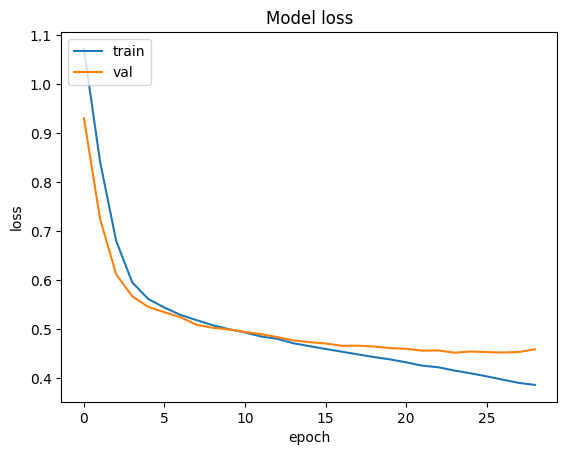

'\n281/281 [==============================] - 877s 3s/step - loss: 0.4031 - val_loss: 0.4527\n\nEpoch 00001: val_loss did not improve from 0.45263\nEpoch 2/25\n281/281 [==============================] - 892s 3s/step - loss: 0.3963 - val_loss: 0.4518\n\nEpoch 00002: val_loss improved from 0.45263 to 0.45182, saving model to tmp4/weights.02.hdf5\nEpoch 3/25\n281/281 [==============================] - 901s 3s/step - loss: 0.3897 - val_loss: 0.4528\n\nEpoch 00003: val_loss did not improve from 0.45182\nEpoch 4/25\n281/281 [==============================] - 911s 3s/step - loss: 0.3855 - val_loss: 0.4583\n\nEpoch 00004: val_loss did not improve from 0.45182\nEpoch 5/25\n281/281 [==============================] - 889s 3s/step - loss: 0.3795 - val_loss: 0.4543\n\nEpoch 00005: val_loss did not improve from 0.45182\nEpoch 6/25\n281/281 [==============================] - 883s 3s/step - loss: 0.3738 - val_loss: 0.4721\n\nEpoch 00006: val_loss did not improve from 0.45182\nEpoch 7/25\n281/281 [====

In [ ]:
# Model loss con lr = 0.00001
plt.plot([1.0722, 0.8420, 0.6799, 0.5950, 0.5610, 0.5435, 0.5286, 0.5178, 
          0.5075, 0.4994, 0.4928, 0.4844, 0.4798, 0.4707, 0.4648, 0.4590, 
          0.4535, 0.4479, 0.4425, 0.4378, 0.4317, 0.4249, 0.4216, 0.4149, 
          0.4093, 0.4031, 0.3963, 0.3897, 0.3855])
plt.plot([0.9305, 0.7250, 0.6114, 0.5667, 0.5448, 0.5340, 0.5239, 0.5083, 
          0.5022, 0.4990, 0.4938, 0.4893, 0.4832, 0.4764, 0.4730, 0.4702,
          0.4655, 0.4657, 0.4640, 0.4608, 0.4594, 0.4555, 0.4560, 0.4514, 
          0.4537, 0.4527, 0.4518, 0.4528, 0.4583])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#### Lectura shuffled map para la implementación del área bajo de curva**

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


Shape of other_map (240, 320)


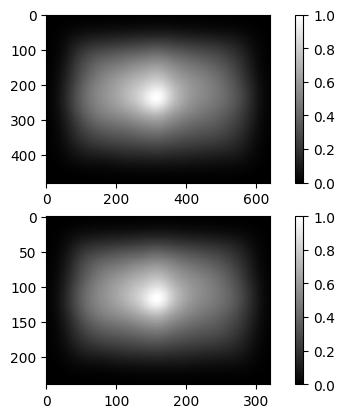

In [ ]:
# Leer y preprocesar el mapa de fijación  -----------------------------------
other_map = color.rgb2gray(io.imread("sAUC/other_map_gauss.png"))

plt.subplot(2,1,1)
plt.imshow(other_map, cmap='gray')
plt.colorbar()

other_map = rescale(other_map, (1.0 / 2.0), anti_aliasing=False)   #Reducción a la mitad
print("Shape of other_map",other_map.shape)

plt.subplot(2,1,2)
plt.imshow(other_map, cmap='gray')
plt.colorbar()
plt.show()
#------------------------------------------------------------------------------

In [ ]:
# Se evalúan todas las predicciones en el conjunto TEST
NSS_m = 0
KL_m = 0
sAUC_m = 0

# Se obtienen los mapas de predicción y se guardan
smaps = [path_predic + f for f in os.listdir(path_predic) if f.endswith(('.jpg', '.jpeg', '.png'))]
maps = [path_maps_test + f for f in os.listdir(path_maps_test) if f.endswith(('.jpg', '.jpeg', '.png'))]
fixs = [path_fixs_test + f for f in os.listdir(path_fixs_test) if f.endswith(('.jpg', '.jpeg', '.png'))]
smaps.sort()
maps.sort()
fixs.sort()

matrix = np.zeros((len(smaps),3))

for i in range(len(smaps)):
  # Y = mapas preprocesados
  Y = io.imread(maps[i])
  Y = rescale(Y.astype(np.float32), 1.0 / 2.0, anti_aliasing=False)   #Se reduce a la mitad
  Y /= 255.0
        
  # F = fijaciones preprocesadas
  F = color.rgb2gray(io.imread(fixs[i]))
  F = rescale(F.astype(np.float32), 1.0 / 2.0, anti_aliasing=False)   #Se reducen a la mitad
  F = normalize_map(F)
  r,c = np.nonzero(F)
  # Después de cambiar la escala, los valores de intensidad cambian -> Conversión de imagen a binaria
  for j in range (len(r)):
    F[ r[j],c[j] ] = 1
   
  # smap = saliency maps preprocesados
  smap = color.rgb2gray(io.imread(smaps[i]))
  #smap = gaussian_filter(smap, 2)

  #Evaluación
  NSS = nss(smap,F)
  KL = kldiv(smap,Y)
  sAUC = sAUC_Zhang(smap, F, other_map )
  
  NSS_m += NSS 
  KL_m += KL
  sAUC_m += sAUC
  
  #Se guardan las evaluaciones en una matriz
  matrix[i,0] = NSS
  matrix[i,1] = KL
  matrix[i,2] = sAUC
  
  if (i % 500) == 0:
    print(matrix[i],"i= ", i)

print(NSS_m/len(smaps))
print(KL_m/len(smaps))
print(sAUC_m/len(smaps))


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


[0.64544645 0.36084673 0.57275945] i=  0
[0.90005471 0.21054957 0.5582323 ] i=  500
[1.38024385 0.52610878 0.68101264] i=  1000
[2.65842231 0.41204342 0.88819501] i=  1500
[2.13936794 0.5427667  0.82809775] i=  2000
[2.26171187 0.58664693 0.83218463] i=  2500
[1.92056956 0.42200336 0.83691156] i=  3000
[0.88428327 0.17356954 0.56445114] i=  3500
[2.01352144 0.6427048  0.81679825] i=  4000
[1.46240938 0.86032607 0.88831019] i=  4500
1.465567440559221
0.4373982788587102
0.7134179984184019
